In [1]:
# import all libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gensim
from textblob import TextBlob
from tqdm import tqdm
from numpy import log, sqrt
# For modelling
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,validation_curve,cross_validate,cross_val_score,learning_curve
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.svm import LinearSVC,SVC
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [2]:
df_final = pd.read_feather("data/df_final.feather")

In [3]:
def discretization(x):
    if x > 6.9: return 1
    else: return 0

df_final["Average score"] = df_final["Average score"].apply(lambda x: discretization(x))

In [4]:
from collections import Counter
Counter(df_final["Average score"])

Counter({1: 209030, 0: 1255})

In [5]:
X = df_final.iloc[:, :50]
y = df_final.iloc[:,51]

In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.4, random_state=32)
X_smo, y_smo = smote.fit_sample(X, y)

In [7]:
X_smo["Review"] = y_smo

In [8]:
df_balanced = X_smo

In [9]:
df_balanced.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Review
0,-0.172850,0.054249,1.331955,0.624849,-0.289155,0.352968,-0.168172,-0.026205,0.202216,0.207798,...,0.960765,-0.409866,0.665558,-1.174518,0.394543,-0.461035,0.561439,0.387918,-0.116501,1
1,-1.000408,-1.492268,1.580612,1.604159,0.080560,2.180467,-0.874364,0.136403,-0.477645,0.127737,...,-0.180197,-0.088430,0.152311,-2.935486,1.093438,1.591154,0.095329,1.272898,-0.357847,1
2,-1.340827,-0.015176,1.288301,1.518229,-0.263480,1.270910,-0.058099,0.376789,-0.109766,0.134260,...,1.028206,-0.863812,-0.259800,-2.160436,0.234394,1.207856,0.688972,1.361456,-0.100542,1
3,-0.641008,-0.350837,-0.236163,1.827108,0.733946,0.815207,-0.349609,0.291637,-0.944925,0.434456,...,1.034008,-0.312193,1.007967,-0.990584,0.524995,-0.357787,-0.171655,0.297890,-1.260579,1
4,-2.314118,-0.464722,0.678646,1.288942,0.647862,4.017908,-0.183250,-0.242754,-0.014459,0.183640,...,-0.032328,-1.314451,1.484645,-1.331208,0.995373,0.405309,-1.083297,1.158279,-1.147393,1


In [10]:
X_b = df_balanced.iloc[:, :50]
y_b = df_balanced.iloc[:,50]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_b,y_b,test_size=0.3,random_state=32)

In [12]:
# using gridsearch to find optimal hyperparameter of Logistic Regression
param_grid_lr = {
    'C' : [0.01,0.1,0.5,5,10,20,50,100],
    'multi_class':['multinomial','ovr'],
 
}

# Create grid search object
if __name__ == "__main__":
    grids_lr = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid = param_grid_lr, cv = 5, verbose=10, n_jobs=-1)

# Fit on data
    best_grids_lr = grids_lr.fit(X_train, y_train)
    print("Best score: %0.3f" % best_grids_lr.best_score_)
    print("Best parameters set:")
    best_parameters = best_grids_lr.best_estimator_.get_params()
    for param_name in sorted(param_grid_lr.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   35.6s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   36.5s finished


Best score: 0.813
Best parameters set:
	C: 0.5
	multi_class: 'multinomial'


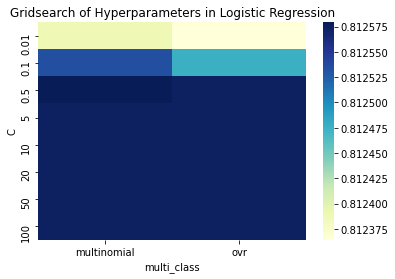

In [13]:
# visualizing results of gridsearch of hyperparameters in Logistic Regression
lr_score = grids_lr.cv_results_['mean_test_score'].reshape(8,2)
sns.heatmap(lr_score,xticklabels=param_grid_lr['multi_class'],yticklabels=param_grid_lr['C'],cmap="YlGnBu")
plt.title('Gridsearch of Hyperparameters in Logistic Regression')
plt.xlabel('multi_class')
plt.ylabel('C')
plt.show()

In [14]:
# fitting optimal hyperparameter to the model
lr = LogisticRegression(C=0.5,solver='lbfgs',multi_class='multinomial').fit(X_train,y_train)
lr.score(X_train,y_train),lr.score(X_test,y_test)

(0.8125936665543888, 0.8118756620687299)

              precision    recall  f1-score   support

           0       0.70      0.60      0.65     25067
           1       0.85      0.90      0.87     62726

    accuracy                           0.81     87793
   macro avg       0.77      0.75      0.76     87793
weighted avg       0.81      0.81      0.81     87793



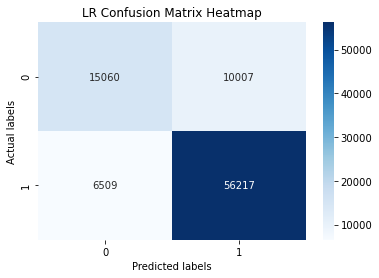

In [15]:
lr_pre = lr.predict(X_test)
print(classification_report(y_test,lr_pre))
matrix_lr = confusion_matrix(y_test,lr_pre)
sns.heatmap(matrix_lr, annot = True, fmt='d',xticklabels=['0','1'],yticklabels=['0','1'],cmap='Blues')
plt.title('LR Confusion Matrix Heatmap')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [16]:
# https://scikit-learn.org/0.16/auto_examples/model_selection/plot_learning_curve.html
# function to draw learning curve
##############################################################################
def plot_learning_curve(estimator, title, X, y, cv=5,
                        n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5),verbose=10):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
   
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, color="r",
                     label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    
    plt.plot(train_sizes, test_scores_mean,color="g",label="Test score")
    
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/weishiwen/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

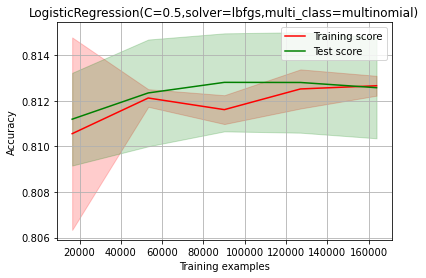

In [17]:
plot_learning_curve(LogisticRegression(C=10,solver='lbfgs',multi_class='multinomial'), 'LogisticRegression(C=0.5,solver=lbfgs,multi_class=multinomial)', X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

In [18]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

In [20]:
cm = confusion_matrix(y_test,pred_test)
#Extract TN, FP, FN,TP values
TN, FP, FN, TP = confusion_matrix(y_test,pred_test).ravel()
sensitivity_score_dc = TP/(FN+TP)
specificity_score_dc = TN/(TN+FP)
print('Sensitivity for Logistic Regression Model = %s' %(sensitivity_score_dc))
print('Specificity for Logistic Regression Model = %s' %(specificity_score_dc))  

Sensitivity for Logistic Regression Model = 0.896231227879986
Specificity for Logistic Regression Model = 0.6007898831132564
